In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.loc[:, ['LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea','SalePrice']]

,LotArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,SalePrice
0,8450,706,0,150,856,856,854,0,1710,208500
1,9600,978,0,284,1262,1262,0,0,1262,181500
2,11250,486,0,434,920,920,866,0,1786,223500
3,9550,216,0,540,756,961,756,0,1717,140000
4,14260,655,0,490,1145,1145,1053,0,2198,250000
5,14115,732,0,64,796,796,566,0,1362,143000
6,10084,1369,0,317,1686,1694,0,0,1694,307000
7,10382,859,32,216,1107,1107,983,0,2090,200000
8,6120,0,0,952,952,1022,752,0,1774,129900
9,7420,851,0,140,991,1077,0,0,1077,118000


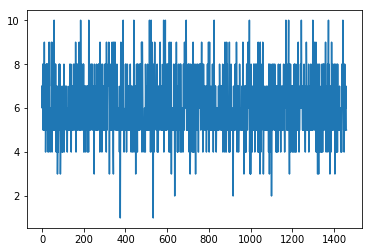

In [6]:
plt.plot(train['OverallQual'])

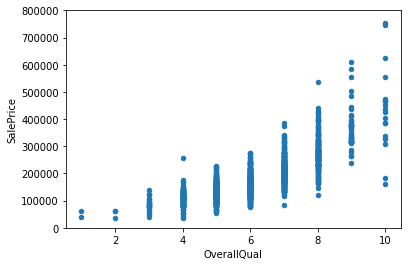

In [8]:
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

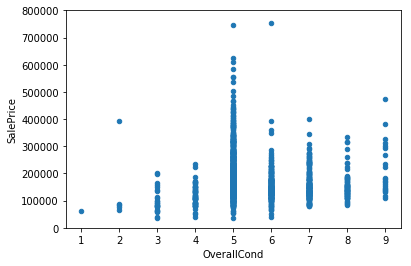

In [9]:
var = 'OverallCond'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

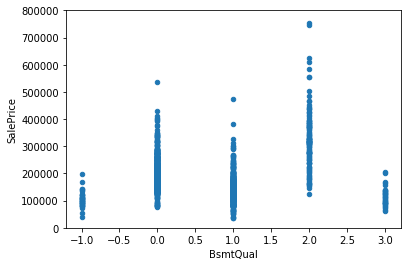

In [18]:
var = 'BsmtQual'
data = pd.concat([train['SalePrice'], pd.DataFrame({var : pd.factorize(train[var])[0]})], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

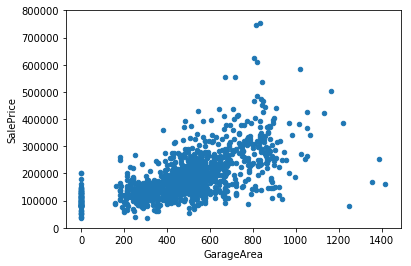

In [21]:
var = 'GarageArea'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

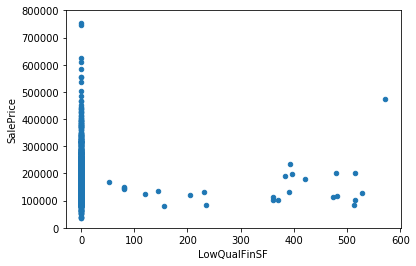

In [22]:
var = 'LowQualFinSF'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

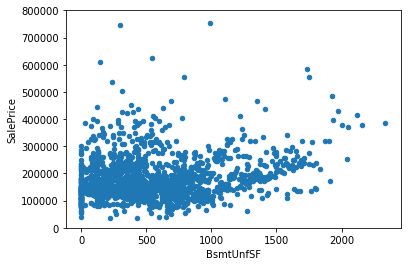

In [23]:
var = 'BsmtUnfSF'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

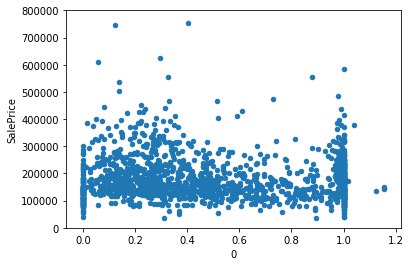

In [26]:
var = 'BsmtUnfSF'
data = pd.concat([train['SalePrice'], train[var]/train['1stFlrSF']], axis = 1)
data.plot.scatter(x = 0, y = 'SalePrice', ylim = (0, 800000))

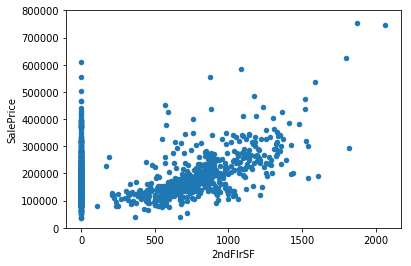

In [31]:
var = '2ndFlrSF'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

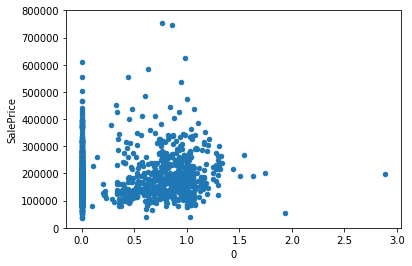

In [28]:
var = '2ndFlrSF'
data = pd.concat([train['SalePrice'], train[var]/train['1stFlrSF']], axis = 1)
data.plot.scatter(x = 0, y = 'SalePrice', ylim = (0, 800000))

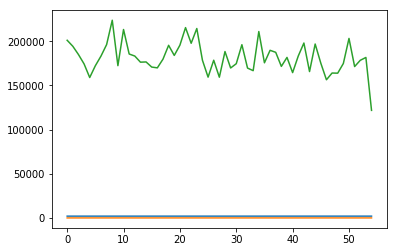

In [44]:
plt.plot(train.groupby(['YrSold', 'MoSold'], as_index=False)['SalePrice'].mean())

In [49]:
train.groupby(['Neighborhood'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,Neighborhood,SalePrice
15,NoRidge,335295.317073
16,NridgHt,316270.623377
22,StoneBr,310499.000000
23,Timber,242247.447368
24,Veenker,238772.727273
21,Somerst,225379.837209
4,ClearCr,212565.428571
6,Crawfor,210624.725490
5,CollgCr,197965.773333
0,Blmngtn,194870.882353


In [50]:
train.groupby(['SaleType'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,SaleType,SalePrice
6,New,274945.418033
2,Con,269600.000000
1,CWD,210600.000000
4,ConLI,200390.000000
8,WD,173401.836622
0,COD,143973.255814
5,ConLw,143700.000000
3,ConLD,138780.888889
7,Oth,119850.000000


In [55]:
train['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [51]:
train.groupby(['BldgType'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,BldgType,SalePrice
0,1Fam,185763.807377
4,TwnhsE,181959.342105
3,Twnhs,135911.627907
2,Duplex,133541.076923
1,2fmCon,128432.258065


In [59]:
test['BldgType'].value_counts()

1Fam      1205
TwnhsE     113
Duplex      57
Twnhs       53
2fmCon      31
Name: BldgType, dtype: int64

In [57]:
train['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [58]:
test['Street'].value_counts()

Pave    1453
Grvl       6
Name: Street, dtype: int64

In [60]:
test['MSSubClass'].value_counts()

20     543
60     276
50     143
120     95
30      70
70      68
160     65
80      60
90      57
190     31
85      28
180      7
75       7
45       6
40       2
150      1
Name: MSSubClass, dtype: int64

In [61]:
train.groupby(['MSSubClass'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,MSSubClass,SalePrice
5,60,239948.501672
11,120,200779.080460
7,75,192437.500000
0,20,185224.811567
8,80,169736.551724
6,70,166772.416667
2,40,156125.000000
9,85,147810.000000
4,50,143302.972222
12,160,138647.380952


In [63]:
test['MSZoning'].value_counts()

RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64

In [62]:
train.groupby(['MSZoning'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,MSZoning,SalePrice
1,FV,214014.061538
3,RL,191004.994787
2,RH,131558.375000
4,RM,126316.830275
0,C (all),74528.000000


In [64]:
test['LotConfig'].value_counts()

Inside     1081
Corner      248
CulDSac      82
FR2          38
FR3          10
Name: LotConfig, dtype: int64

In [65]:
train.groupby(['LotConfig'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,LotConfig,SalePrice
1,CulDSac,223854.617021
3,FR3,208475.000000
0,Corner,181623.425856
2,FR2,177934.574468
4,Inside,176938.047529


In [72]:
train['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [69]:
train.groupby(['HouseStyle'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,HouseStyle,SalePrice
3,2.5Fin,220000.000000
5,2Story,210051.764045
2,1Story,175985.477961
7,SLvl,166703.384615
4,2.5Unf,157354.545455
0,1.5Fin,143116.740260
6,SFoyer,135074.486486
1,1.5Unf,110150.000000


In [71]:
test['RoofMatl'].value_counts()

CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64

In [73]:
train['RoofMatl'].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
Membran       1
Metal         1
ClyTile       1
Name: RoofMatl, dtype: int64

In [70]:
train.groupby(['RoofMatl'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,RoofMatl,SalePrice
7,WdShngl,390250.000000
2,Membran,241500.000000
6,WdShake,241400.000000
5,Tar&Grv,185406.363636
3,Metal,180000.000000
1,CompShg,179803.679219
0,ClyTile,160000.000000
4,Roll,137000.000000


In [76]:
test['RoofStyle'].value_counts()

Gable      1169
Hip         265
Gambrel      11
Flat          7
Mansard       4
Shed          3
Name: RoofStyle, dtype: int64

In [74]:
train['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [75]:
train.groupby(['RoofStyle'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,RoofStyle,SalePrice
5,Shed,225000.000000
3,Hip,218876.933566
0,Flat,194690.000000
4,Mansard,180568.428571
1,Gable,171483.956179
2,Gambrel,148909.090909


In [80]:
test['BsmtQual'].value_counts()

TA    634
Gd    591
Ex    137
Fa     53
Name: BsmtQual, dtype: int64

In [79]:
train['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [78]:
train.groupby(['BsmtQual'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,BsmtQual,SalePrice
0,Ex,327041.041322
2,Gd,202688.478964
3,TA,140759.818182
1,Fa,115692.028571


In [56]:
train.groupby(['Street'], as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False)

,Street,SalePrice
1,Pave,181130.538514
0,Grvl,130190.500000


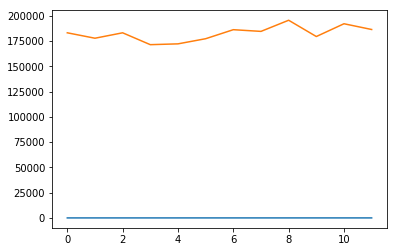

In [46]:
plt.plot(train.groupby(['MoSold'], as_index=False)['SalePrice'].mean())

In [ ]:
BsmtQual

In [ ]:
train[train['TotalBsmtSF']==0].shape

In [ ]:
test[test['TotalBsmtSF']==0].shape

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
train.describe()

In [ ]:
train.describe(include=['O'])

In [ ]:
train[train.columns[train.dtypes!=object]].skew()

In [ ]:
train[train.columns[train.dtypes!=object]].kurt()

In [ ]:
train_skew = train[train.columns[train.dtypes!=object]].skew()

In [ ]:
plt.plot(train.groupby(['YrSold', 'MoSold'], as_index=False)['SalePrice'].mean())

In [ ]:
train[train['SalePrice']>700000]

In [ ]:
plt.plot(train_skew)

In [ ]:
skewed_columns = train_skew.index[train_skew.abs()>1.5]

In [ ]:
y_train = train['SalePrice'].values

In [ ]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
all_data = pd.concat([train, test], axis=0)

In [ ]:
all_data.shape

In [ ]:
all_data_skew = all_data[all_data.columns[train.dtypes!=object]].skew()
skewed_columns = all_data_skew.index[all_data_skew.abs()>1.5]

In [ ]:
skewed_columns

In [ ]:
stats.skew(np.log(y_train))

In [ ]:
sns.distplot(y_train)

In [ ]:
all_data.isnull().sum().sort_values(ascending=False)

In [ ]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

In [ ]:
#all_data['OverallQual+Cond'] =(all_data['OverallQual']).astype(str) + (all_data['OverallCond']).astype(str)
#all_data['OverallQual*Cond'] =(all_data['OverallQual'] * all_data['OverallCond']).astype(str)
all_data['OverallQual'] = all_data['OverallQual'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

all_data['Neigh_Zone']  = all_data['Neighborhood'].astype(str) +'_'+ all_data['MSZoning'].astype(str)
all_data['SaleType_Condition']  = all_data['SaleType'].astype(str) +'_'+ all_data['SaleCondition'].astype(str)

In [ ]:
col_obj = all_data.columns[all_data.dtypes==object]
col_obj

all_data['TotalBsmt_0'] = (all_data['TotalBsmtSF']==0).astype(int)
all_data['1st-TotalBsmtSF'] = all_data['1stFlrSF'] - all_data['TotalBsmtSF']
all_data['2ndFlr_Flag'] = (all_data['2ndFlrSF']!=0).astype(int)
all_data['BsmtUnfRate'] = all_data['BsmtUnfSF']/all_data['1stFlrSF']
all_data['LowQualRate'] = all_data['LowQualFinSF']/all_data['GrLivArea']
all_data['1st/Lot']     = all_data['1stFlrSF']/all_data['LotArea']
all_data['1st+2ndSF']   = all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['2nd/1st']     = all_data['2ndFlrSF'] / all_data['1stFlrSF']
all_data['YearRemo-Gar'] = all_data['YearRemodAdd'] - all_data['GarageYrBlt']
all_data['1st+2nd+GarSF']= all_data['1st+2ndSF'] + all_data['GarageArea']
all_data['1st+2nd+Gar/Lot'] = all_data['1st+2nd+GarSF'] / all_data['LotArea']

In [ ]:
col_obj = all_data.columns[all_data.dtypes==object]
col_obj

In [ ]:
for col in col_obj:
    all_data[col] = all_data[col].factorize()[0]

In [ ]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

In [ ]:
sns.distplot(all_data['LotFrontage'].notnull())

In [ ]:
plt.plot(all_data['LotFrontage'])

In [ ]:
all_data['LotFrontage'].mean()

In [ ]:
all_data['LotArea']

In [ ]:
all_data['LotFrontage'].notnull()

In [ ]:
all_data['GarageYrBlt'].fillna(0, inplace=True)

In [ ]:
all_data['MasVnrArea']

In [ ]:
all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median()

In [ ]:
all_data['MasVnrArea'].fillna(all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median(), inplace=True)

In [ ]:
all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)

In [ ]:
all_data.fillna(all_data.mean(), inplace=True)

In [ ]:
all_data.skew()

In [ ]:
sns.distplot((all_data['LotArea']))

In [ ]:
plt.plot((all_data['LotArea']))

In [ ]:
all_data['LotArea'].mean()

In [ ]:
#np.percentile(all_data['LotArea'], 95)

In [ ]:
#all_data['LotArea'] = np.clip(all_data['LotArea'], a_min=all_data['LotArea'].min(), a_max=np.percentile(all_data['LotArea'], 95))

In [ ]:
sns.distplot((all_data['LotArea']))

In [ ]:
all_data.head()

In [ ]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [ ]:
test_id = test['Id'].values

In [ ]:
del train['Id'], test['Id']

In [ ]:
y_train_log = np.log(y_train)

In [ ]:
plt.scatter(x=train['GrLivArea'], y=y_train)

In [ ]:
train[train['GrLivArea']>4000]['GrLivArea']

In [ ]:
train = pd.concat([train, pd.DataFrame({'SalePrice':y_train})], axis=1)

In [ ]:
train.drop(train[train['GrLivArea']>4600].index, inplace=True)

In [ ]:
train.shape

In [ ]:
def mean_encoding(train, test, cols):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    skf = skf.split(train, train['SalePrice'])
    for col in cols:
        train[col+'_mean_encoding'] = 0
        test[col+'_mean_encoding'] = test[col].map(train.groupby(col)['SalePrice'].mean())
    for tr_idx,val_idx in skf:
        X_tr, X_val = train.iloc[tr_idx, :], train.iloc[val_idx, :]
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col)['SalePrice'].mean())
            train[col+'_mean_encoding'].iloc[val_idx] = means
    prior = train['SalePrice'].mean()
    train.fillna(prior, inplace=True)
    test.fillna(prior, inplace=True)
    return train,test

In [ ]:
#train, test = mean_encoding(train, test, col_obj)

In [ ]:
train.head()

In [ ]:
plt.plot(train['MiscVal'])

In [ ]:
plt.plot(test['MiscVal'])

In [ ]:
plt.scatter(x=train['LotArea'], y=train['SalePrice'])

In [ ]:
train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

In [ ]:
res = stats.probplot(np.log(train['LotArea']), plot=plt)

In [ ]:
res = stats.probplot(train['LotArea'], plot=plt)

In [ ]:
res = stats.probplot(train['SalePrice'], plot=plt)

In [ ]:
res = stats.probplot(np.log(train['SalePrice']), plot=plt)

In [ ]:
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

In [ ]:
res = stats.probplot(np.log(train['TotalBsmtSF']), plot=plt)

In [ ]:
res = stats.probplot(np.log(train['GrLivArea']), plot=plt)

In [ ]:
res = stats.probplot(train['GrLivArea'], plot=plt)

In [ ]:
sf_cols = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
          'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

In [ ]:
cols = ['TotalBsmtSF', 'LotArea']

for df in [train, test]:
    #df['GrLivArea_log'] = np.log(df['GrLivArea'])        
    #df['YrRem-Bui'] = df['YearRemodAdd'] - df['YearBuilt']
    for col in sf_cols:
        df[col+'_sqrt'] = np.sqrt(df[col]) 
        df[col+'_log'] = np.zeros(df.shape[0])
        df[col+'_log'].loc[df[df[col]>0].index] = np.log(df[col])

In [ ]:
y_train = train['SalePrice'].values
del train['SalePrice']

In [ ]:
all_data = pd.concat([train, test], axis=0)
#ob_col = all_data.columns[all_data.dtypes==object]

In [ ]:
#all_data.fillna('NA', inplace=True)
all_data[col_obj] = all_data[col_obj].astype(str)
all_data = pd.get_dummies(all_data)

In [ ]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [ ]:
train.shape

In [ ]:
y_train_log = np.log(y_train)

In [ ]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=False, random_state=123)

In [ ]:
ss = StandardScaler()
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.linear_model import LinearRegression, Lasso

reg_lasso = []
val_rmse_lasso = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.001).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

coef = pd.Series(model_lasso.coef_, index = train.columns)

coef

dropf = coef.loc[coef==0].index
print(dropf)

In [ ]:
train = train.drop(dropf, axis=1)

In [ ]:
coef.sort_values(ascending=False)

In [ ]:
lgb_params = {
               'feature_fraction': 0.75,
               'max_depth': 4,
               'metric': 'rmse',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

In [ ]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

In [ ]:
np.sum(val_rmse)/n_folds

In [ ]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance()

In [ ]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

In [ ]:
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

C = [10**i for i in range(0,3)]
epsilon = [10**i for i in range(-4,-1)]
gamma = [10**i for i in range(-5,-2)]

tuned_parameters = {'C':C, 'epsilon':epsilon, 'gamma':gamma}

svr = RandomizedSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = 4,
    cv=4, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


svr.fit(train_ss, y_train_log)
print(np.sqrt(-svr.best_score_))
print(svr.best_params_)

In [ ]:
preds = svr.predict(test_ss)

In [ ]:
drop_f2 = importance[importance['Importance']==0].index

In [ ]:
for df in [train, test]:
    df = df.drop(drop_f2, axis=1)

In [ ]:
train = train.drop(drop_f2, axis=1)

In [ ]:
test = test.drop(dropf, axis=1)
test = test.drop(drop_f2, axis=1)

In [ ]:
reg_lasso = []
val_rmse_lasso = []

ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.005).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

In [ ]:
preds = None

for model in reg:
    if preds is None:
        preds = model.predict(test) / n_folds
    else:
        preds += model.predict(test) / n_folds

In [ ]:
np.exp(preds)

In [ ]:
sns.distplot(np.exp(preds))

In [ ]:
solution = pd.DataFrame({"id":test_id, "SalePrice":np.exp(preds)})
solution.to_csv("submission_34.csv", index = False)